## Strikes Per Flight, According to Time of Day

### Goal

The goal of this notebook is look for time-of-day patterns in the frequency of bird strikes.

We find the number of bird strikes per flight for each hour of the day. In other words, for each hour (0 to 23), we take the number of bird strikes reported for that hour and divide by the number of flights scheduled to depart during that hour. 

### Data sources

The bird strike data comes from the FAA Wildlife Strike Database: https://wildlife.faa.gov/search

The flight data comes from the FAA Aviation System Performance Metrics website: https://aspm.faa.gov/apm/sys/AnalysisAP.asp

From both data sets, we use all available data from 2000 to 2019.

### Caveats

1. Approximately half of the strike reports do not have a specific time associated to them. We do not consider these reports here. Therefore, when we talk about the number of strikes reported in a given hour, this is probably lower than the actual number of strikes that occured during that hour.


2. For simplicity, when considering the number of flights in a given hour, we have only worked with scheduled departure times. Since bird strikes can happen at other parts of the flight (not just departure), and because many flights are delayed for reasons unrelated to bird strikes, it might be worth considering a more sophisticated way to measure number of flights.

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
# Load in the strike data
strikes = pd.read_csv("strikes_2000_2019.csv")

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14,16,77,86,96,99) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [136]:
# Make a smaller data frame to focus on the strike time and place
strike_times = strikes[['INDX_NR','INCIDENT_DATE ','STATE',
                        'AIRPORT_ID', 'OPERATOR_ID','SPECIES_ID',
                        'DAMAGE','COST_REPAIRS',
                        'INCIDENT_MONTH','INCIDENT_YEAR',
                        'TIME_OF_DAY','TIME',
                        'FAAREGION','ENROUTE','LOCATION',
                        'HEIGHT','SPEED','DISTANCE',
                        'PHASE_OF_FLIGHT',
                        'EFFECT_NONE', 'EFFECT_ABORTED', 
                        'EFFECT_PREC_LAND', 'EFFECT_ENG_SHUT', 
                        'EFFECT_OTH', 'EFFECT_OTHER',
                        'SKY', 'PRECIP_FOG', 'PRECIP_RAIN', 
                        'PRECIP_SNOW', 'PRECIP_NONE', 
                        'BIRDS_SEEN', 'BIRDS_STRUCK', 'SIZE', 
                        'WARNED', 'REMARKS', 'AOS',
                        'OTHER_COST', 'COST_REPAIRS_INFL_ADJ', 
                        'COST_OTHER_INFL_ADJ','COMMENT',
                        'INDICATED_DAMAGE']]

In [137]:
# Convert the 'INCIDENT_DATE ' column to datetime format
strike_times['INCIDENT_DATE '] = pd.to_datetime(strike_times['INCIDENT_DATE '])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [138]:
# In the TIME column in the original data set, 
# empty entries are denoted by the string '     '.
# Here we replace all strings of 5 spaces with NaN
# to make empty entries in the TIME column easier to identify.
strike_times = strike_times.replace('     ', np.nan)

# Convert the times in the 'TIME' column to datetime format
# Unfortunately this assigns a date of 1900-01-01
strike_times['TIME'] = pd.to_datetime(strike_times['TIME'], 
                                      format= '%H:%M')


### Toy example: 2018

Let's start by looking at the data from 2018 alone.

In [139]:
# Load in the flight data
# The first line of the data file from FAA ASPM contains title information,
# and the last line of the data file is a "Total:" row
# Use skiprows = [0, 26] to avoid reading in these two lines
flights_2018 = pd.read_csv("flights_hourly/flights_hourly_2018.csv", 
                           skiprows = [0, 26])

In [140]:
flights_2018.head()

,Hour,ScheduledDepartures,ScheduledArrivals,DeparturesFor MetricComputation,ArrivalsFor MetricComputation,% On-TimeGateDepartures,% On-TimeAirportDepartures,% On-TimeGateArrivals,AverageGateDepartureDelay,AverageTaxiOutTime,AverageTaxiOutDelay,AverageAirportDepartureDelay,AverageAirborneDelay,AverageTaxiInDelay,AverageBlockDelay,AverageGateArrivalDelay
0,0,31874,97603,40015,141108,77.31,69.42,78.86,10.28,16.61,4.85,13.85,2.02,2.41,3.82,10.32
1,1,16940,21609,27804,45034,78.34,71.98,78.07,9.75,15.84,4.22,12.78,2.29,1.77,3.92,10.77
2,2,5890,5266,28592,18915,72.18,68.81,75.41,12.83,13.11,2.75,14.73,2.04,1.67,3.90,12.57
3,3,4399,2350,55006,14473,59.35,54.46,70.68,17.66,14.04,3.11,20.25,2.13,1.79,3.62,15.13
4,4,3066,17232,44859,44018,54.90,49.10,74.64,20.19,14.60,3.72,23.38,1.31,1.98,3.13,11.96


In [141]:
strike_times_2018 = strike_times.loc[strike_times['INCIDENT_DATE '].dt.year == 2018]

In [149]:
# Reported strikes each hour
strikes_hourly_2018 = strike_times_2018['TIME'].groupby(strike_times_2018['TIME'].dt.hour).count()

# Flights scheduled to depart each hour
flights_hourly_2018 = flights_2018['ScheduledDepartures']

# Strikes per flight each hour
strikes_per_flight_hourly_2018 = [strikes_hourly_2018[h]/flights_hourly_2018[h] for h in range(0,24)]

<BarContainer object of 24 artists>

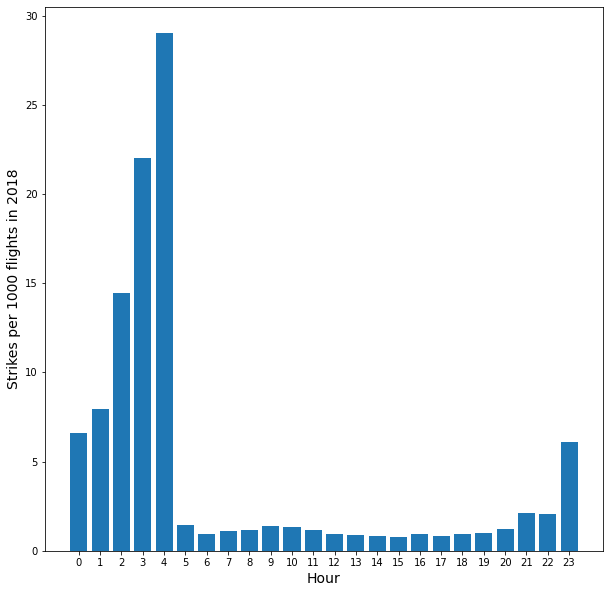

In [143]:
# Plot the strikes per flight for each hour of the day

plt.figure(figsize=(10,10))

plt.xlabel('Hour', fontsize=14)
plt.ylabel('Strikes per 1000 flights in 2018', fontsize=14)

plt.xticks(range(0,24))

plt.bar(range(0,24), [1000*i for i in strikes_per_flight_hourly_2018])

### Strikes reported per 1000 flights, each hour: 2000-2019

We'll do something similar to the above, but with the whole data set.

In [144]:
# Load in the flight data for each year from 2000 through 2019
# Store it as a list called flights,
# where flights[i] = the data frame for the year 2000+i

flights = []

for year in range(0, 20):
    flight_df = pd.read_csv("flights_hourly/flights_hourly_{}.csv".format(str(2000+year)), skiprows = [0, 26])
    flights.append(flight_df)

In [150]:
# Reported strikes each hour
strikes_hourly = strike_times['TIME'].groupby(strike_times['TIME'].dt.hour).count()

# Flights scheduled to depart each hour
flights_hourly = sum([flights[y]['ScheduledDepartures'] for y in range(0,20)])

# Strikes per flight each hour
strikes_per_flight_hourly = [strikes_hourly[h]/flights_hourly[h] for h in range(0,24)]

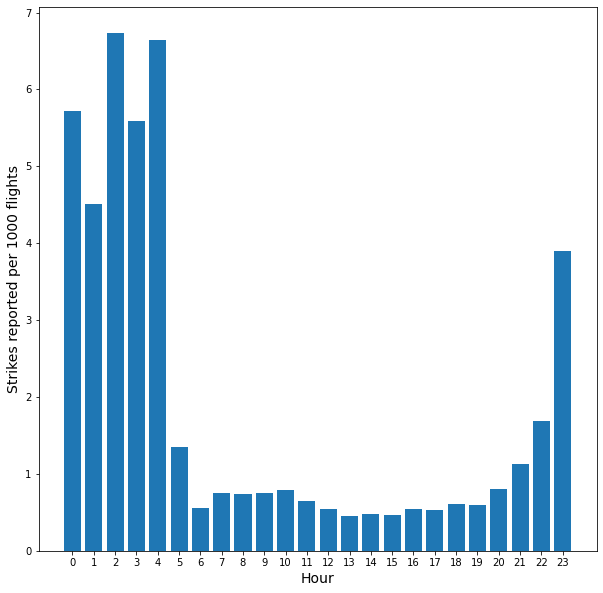

In [162]:
# Plot the strikes per flight for each hour of the day

plt.figure(figsize=(10,10))

plt.xlabel('Hour', fontsize=14)
plt.ylabel('Strikes reported per 1000 flights', fontsize=14)

plt.xticks(range(0,24))

plt.bar(range(0,24), [1000*i for i in strikes_per_flight_hourly])

plt.show()

For comparison, let's plot the bird strikes and the number of flights separately.

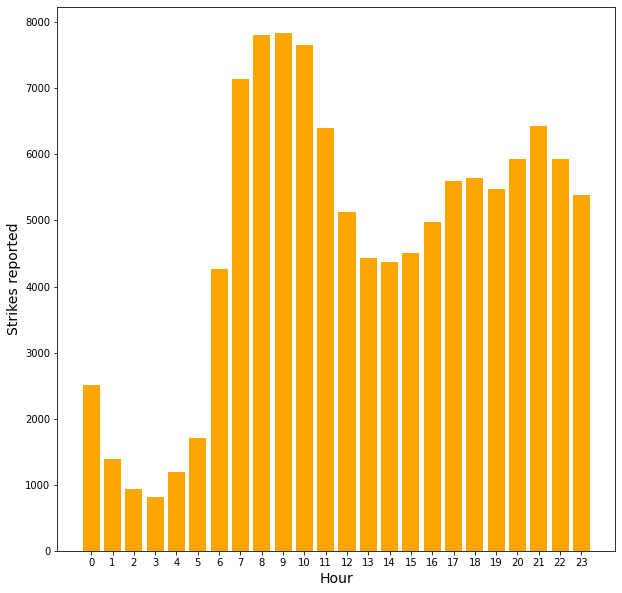

In [163]:
# Plot the number of bird strikes by hour

plt.figure(figsize=(10,10))

plt.xlabel('Hour', fontsize=14)
plt.ylabel('Strikes reported', fontsize=14)

plt.xticks(range(0,24))

plt.bar(range(0,24), strikes_hourly, color='orange')

plt.show()

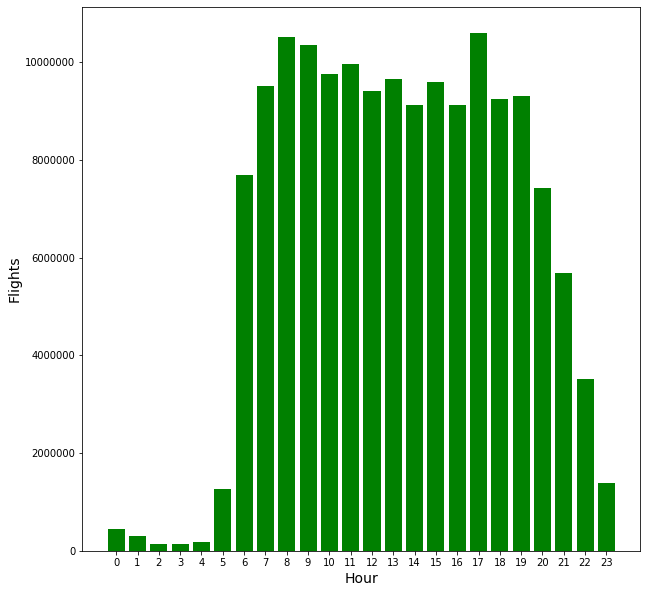

In [170]:
# Plot the number of flights by hour

plt.figure(figsize=(10,10))

plt.xlabel('Hour', fontsize=14)
plt.ylabel('Flights', fontsize=14)

# Write the y-axis labels in plain text
# instead of scientific notation
plt.ticklabel_format(style = 'plain')

plt.xticks(range(0,24))

plt.bar(range(0,24), flights_hourly, color='g')

plt.show()

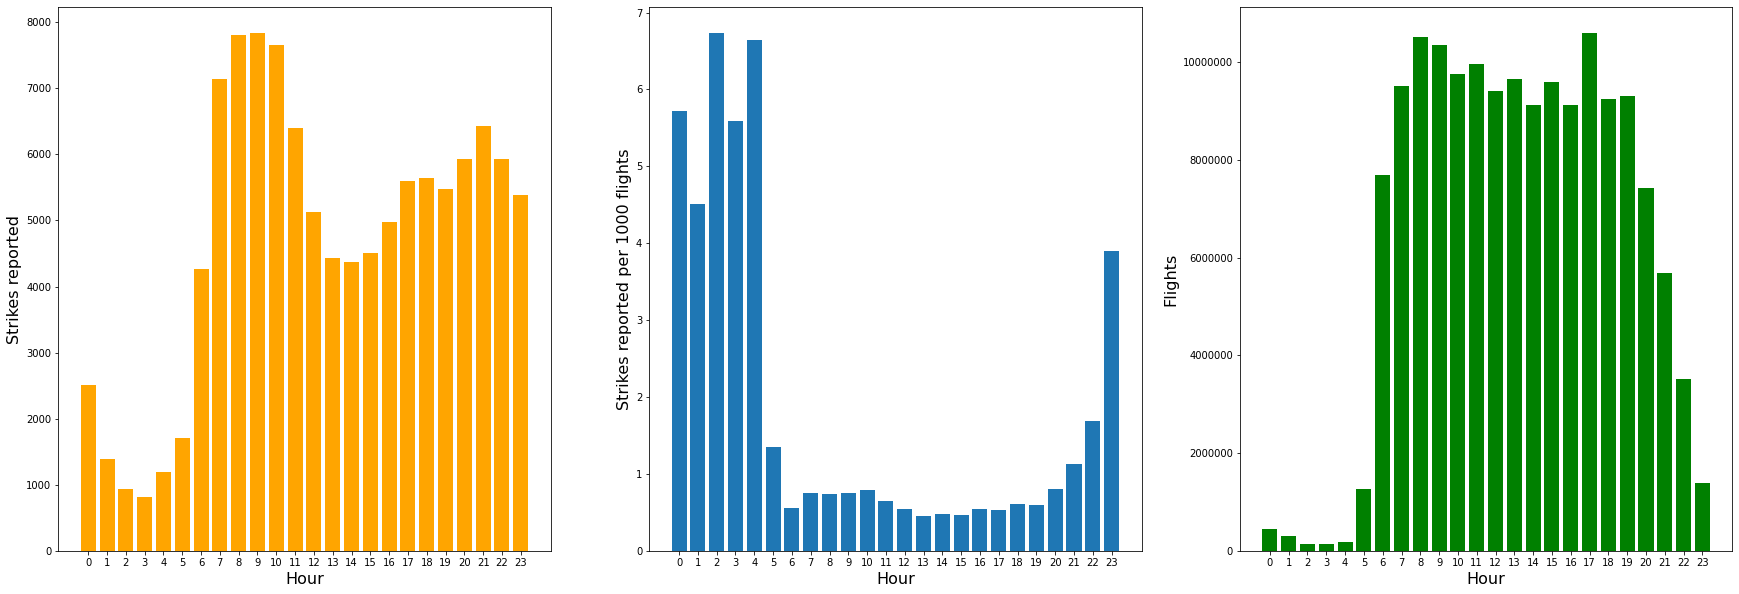

In [240]:
# Now let's plot these three side-by-side

fig, ax = plt.subplots(1,3,sharex=True, figsize=(30,10))

ax[0].set_xticks(range(0,24))

ax[0].bar(range(0,24), strikes_hourly, color='orange')
ax[0].set_xlabel('Hour', fontsize=16)
ax[0].set_ylabel('Strikes reported', fontsize=16)

ax[1].bar(range(0,24), [1000*i for i in strikes_per_flight_hourly])
ax[1].set_xlabel('Hour', fontsize=16)
ax[1].set_ylabel('Strikes reported per 1000 flights', fontsize=16)

ax[2].bar(range(0,24), flights_hourly, color='g')
ax[2].ticklabel_format(style = 'plain')
ax[2].set_xlabel('Hour', fontsize=16)
ax[2].set_ylabel('Flights', fontsize=16)

plt.show()